In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

## load data 

In [2]:
train_feature_df = pd.read_csv('train_feature.csv', low_memory=False)
train_label_df = pd.read_csv('train_label.csv', low_memory=False)
test_feature_df = pd.read_csv('test_feature.csv', low_memory=False)
print(train_feature_df.shape, train_label_df.shape, test_feature_df.shape)

(17008, 8) (2126, 2) (7320, 8)


## 2.1 remake the data for each day
should be 7*8+2=58 cols

In [3]:
train_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = train_feature_df[train_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    train_feature_df_list.append(temp_df )

In [4]:
for i in range(8):
    train_label_df = train_label_df.merge(train_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))

## 3.1 normalize data

In [5]:
fcol = [c for c in train_label_df.columns if c not in ['日期', '时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14',
                                             '时刻_17', '时刻_20', '时刻_23','辐照度_2', '辐照度_5','辐照度_23', '电场实际太阳辐射指数']]

X = train_label_df[fcol].values
y = train_label_df['电场实际太阳辐射指数']

In [6]:
# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Test Dataset

In [7]:
test_feature_df = test_feature_df.iloc[0:7296]
print('dates in test dataset is : ', test_feature_df.shape[0]/8)

dates in test dataset is :  912.0


In [8]:
# initalize the test label
index = np.arange(912)
columns = ['日期']
data = np.array([np.arange(1, 913)]).T
test_label_df = pd.DataFrame(data, index=index, columns=columns)

In [9]:
test_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = test_feature_df[test_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    test_feature_df_list.append(temp_df )
    
for i in range(8):
    test_label_df = test_label_df.merge(test_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))

In [10]:
x_test = test_label_df[fcol].values
x_test = 1 - ((maxs - x_test) / rng)
x_test.shape

(912, 45)

# Neural network

In [38]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(45, input_dim=45, kernel_initializer='normal', activation='relu'))
    model.add(Dense(90, input_dim=45, kernel_initializer='normal', activation='relu'))
    model.add(Dense(45, input_dim=90, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=45, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [81]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)

In [39]:
"""
# evaluate model with standardized dataset
seed = 7
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
"""

In [82]:
estimator.fit(X,y)

Epoch 1/100
2126/2126 [==============================] - 4s 2ms/step - loss: 0.0697
Epoch 2/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0546
Epoch 3/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0536
Epoch 4/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0524
Epoch 5/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0520
Epoch 6/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0515
Epoch 7/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0510
Epoch 8/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0512
Epoch 9/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0512
Epoch 10/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0513
Epoch 11/100
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0507
Epoch 12/100
2126/2126 [==============================] - 3s 1ms/step - lo

2126/2126 [==============================] - 2s 1ms/step - loss: 0.0424
Epoch 98/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0420
Epoch 99/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0424
Epoch 100/100
2126/2126 [==============================] - 2s 1ms/step - loss: 0.0419


In [83]:
predict = estimator.predict(x_test)

912/912 [==============================] - 1s 593us/step


In [84]:
predict[predict>1] = 1

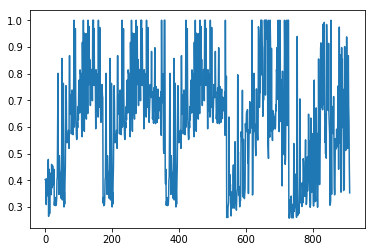

In [85]:
plt.plot(predict)

# Model

In [50]:
num_feature = 45

In [56]:
# Build U-Net model
input_sun = Input((num_feature, ), name='sun_features')

dense = Dense(80, kernel_initializer='normal', activation='relu') (input_sun)
dense = Dense(45, kernel_initializer='normal', activation='relu') (dense)

outputs = Dense(1, kernel_initializer='normal', activation='relu') (dense)

model = Model(inputs=[input_sun], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy') 
model.compile(optimizer='adam', loss='binary_crossentropy')
# The mean_iou metrics seens to leak train and test values...
# A metric is a function that is used to judge the performance of your model. 
# the results from evaluating a metric are not used when training the model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sun_features (InputLayer)    (None, 45)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 80)                3680      
_________________________________________________________________
dense_50 (Dense)             (None, 45)                3645      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 46        
Total params: 7,371
Trainable params: 7,371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds_train = model.predict({'img': X_train, 'feat': X_feat_train}, verbose=1)

# Results
### 2019/10/29 1
- two layers 45->1
- score 0.21

### make submission

In [86]:
data = np.array([np.arange(1, 913)]).T
submission_df = pd.DataFrame(data, index=index, columns=columns)
submission_df['prediction'] = predict
submission_df.rename(columns={'日期':'time'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)